In [ ]:
!pip install --upgrade pip setuptools wheel
!apt install libasound2-dev portaudio19-dev libportaudio2 libportaudiocpp0 ffmpeg
!pip install pycombo
!pip install geopandas

In [ ]:
#add necessary libraries
import pycombo # combo community detection package
import networkx as nx #library supporting networks
import matplotlib.pyplot as plt #plotting
import pandas as pd
import numpy as np
import geopandas as gpd
import scipy.stats as stat
from scipy import optimize
#make sure plots are embedded into the notebook
%pylab inline 
import statsmodels.formula.api as smf
import os
from networkx.algorithms import community
import warnings
warnings.filterwarnings('ignore')

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data2019 = pd.read_csv('/content/drive/MyDrive/MLC Project/E-Scooter_Trips_-_2019_Pilot.csv')
data2020 = pd.read_csv('/content/drive/MyDrive/MLC Project/E-Scooter_Trips_-_2020.csv')
data = pd.concat([data2019, data2020])
data.shape

(1341655, 19)

In [ ]:
data = data.dropna(subset=['Start Community Area Name', 'End Community Area Name'])
data.shape

(1241745, 19)

In [ ]:
data.head(2)

,Trip ID,Start Time,End Time,Trip Distance,Trip Duration,Accuracy,Start Census Tract,End Census Tract,Start Community Area Number,End Community Area Number,Start Community Area Name,End Community Area Name,Start Centroid Latitude,Start Centroid Longitude,Start Centroid Location,End Centroid Latitude,End Centroid Longitude,End Centroid Location,Vendor
10291,0dd95046-1bc8-4464-ba39-7f9e92c668b3,08/06/2019 06:00:00 PM,08/06/2019 06:00:00 PM,1004,236,152.0,1.703120e+10,1.703120e+10,20.0,20.0,HERMOSA,HERMOSA,41.935048,-87.737604,POINT (-87.7376041954734 41.9350481285613),41.935048,-87.737604,POINT (-87.7376041954734 41.9350481285613),NaN
10293,6819df6a-9623-4ae0-b1d3-ec617197d229,07/08/2019 04:00:00 PM,07/08/2019 05:00:00 PM,9124,3182,10.0,1.703115e+10,1.703119e+10,15.0,19.0,PORTAGE PARK,BELMONT CRAGIN,41.949592,-87.761958,POINT (-87.7619580301513 41.9495915671753),41.920143,-87.760827,POINT (-87.7608269556143 41.920143229102),NaN


In [ ]:
data.columns

Index(['Trip ID', 'Start Time', 'End Time', 'Trip Distance', 'Trip Duration',
       'Accuracy', 'Start Census Tract', 'End Census Tract',
       'Start Community Area Number', 'End Community Area Number',
       'Start Community Area Name', 'End Community Area Name',
       'Start Centroid Latitude', 'Start Centroid Longitude',
       'Start Centroid Location', 'End Centroid Latitude',
       'End Centroid Longitude', 'End Centroid Location', 'Vendor'],
      dtype='object')

In [ ]:
community = gpd.read_file('/content/drive/MyDrive/MLC Project/Boundaries - Community Areas (current).geojson').set_index('community')
community['centroid'] = community.geometry.centroid
community.head()

,area,shape_area,perimeter,area_num_1,area_numbe,comarea_id,comarea,shape_len,geometry,centroid
community,,,,,,,,,,
DOUGLAS,0,46004621.1581,0,35,35,0,0,31027.0545098,"MULTIPOLYGON (((-87.60914 41.84469, -87.60915 ...",POINT (-87.61868 41.83512)
OAKLAND,0,16913961.0408,0,36,36,0,0,19565.5061533,"MULTIPOLYGON (((-87.59215 41.81693, -87.59231 ...",POINT (-87.60322 41.82375)
FULLER PARK,0,19916704.8692,0,37,37,0,0,25339.0897503,"MULTIPOLYGON (((-87.62880 41.80189, -87.62879 ...",POINT (-87.63242 41.80909)
GRAND BOULEVARD,0,48492503.1554,0,38,38,0,0,28196.8371573,"MULTIPOLYGON (((-87.60671 41.81681, -87.60670 ...",POINT (-87.61786 41.81295)
KENWOOD,0,29071741.9283,0,39,39,0,0,23325.1679062,"MULTIPOLYGON (((-87.59215 41.81693, -87.59215 ...",POINT (-87.59618 41.80892)


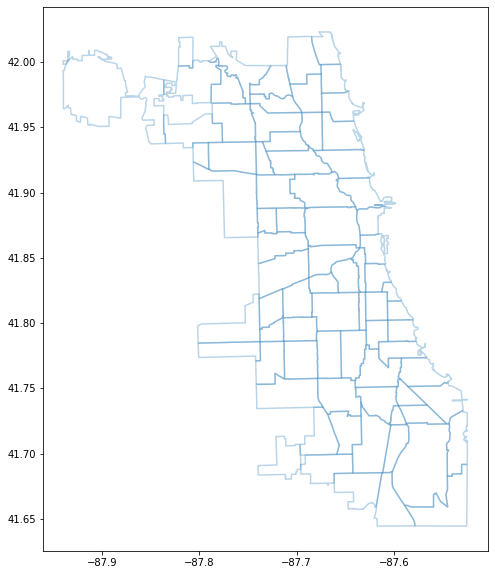

In [ ]:
community.geometry.boundary.plot(figsize=(10,10), alpha=0.3)

In [ ]:
links = data[['Start Community Area Name', 'End Community Area Name']].reset_index()
links = links.groupby(['Start Community Area Name', 'End Community Area Name'], as_index=False).count().\
                                                                    rename(columns={'index': 'count',
                                                                                    'Start Community Area Name': 'start',
                                                                                    'End Community Area Name': 'end'})
links.head()

,start,end,count
0,ALBANY PARK,ALBANY PARK,1525
1,ALBANY PARK,AUSTIN,2
2,ALBANY PARK,AVONDALE,55
3,ALBANY PARK,BELMONT CRAGIN,4
4,ALBANY PARK,DUNNING,2


In [ ]:
links.shape

(2033, 3)

In [ ]:
top_links = links.sort_values(by='count', ascending=False)
top_links.head(10)

,start,end,count
2006,WEST TOWN,WEST TOWN,183104
1332,NEAR WEST SIDE,NEAR WEST SIDE,182059
1061,LOGAN SQUARE,LOGAN SQUARE,75973
956,LAKE VIEW,LAKE VIEW,73717
993,LINCOLN PARK,LINCOLN PARK,55258
1347,NEAR WEST SIDE,WEST TOWN,32208
1985,WEST TOWN,LOGAN SQUARE,27714
1079,LOGAN SQUARE,WEST TOWN,23215
1992,WEST TOWN,NEAR WEST SIDE,23063
240,BELMONT CRAGIN,BELMONT CRAGIN,22013


In [ ]:
#create a dictionary of community locations
ComPos={i: (community['centroid'].x[i], community['centroid'].y[i]) for i in community.index}

In [ ]:
#create a network with city names as nodes
Scooters=nx.Graph()
Scooters.add_nodes_from(community.index)

#create list of edges and weights as tuples
edge_weighted = [(links['start'][i],links['end'][i], links['count'][i]) for i in links.index]
Scooters.add_weighted_edges_from(edge_weighted)

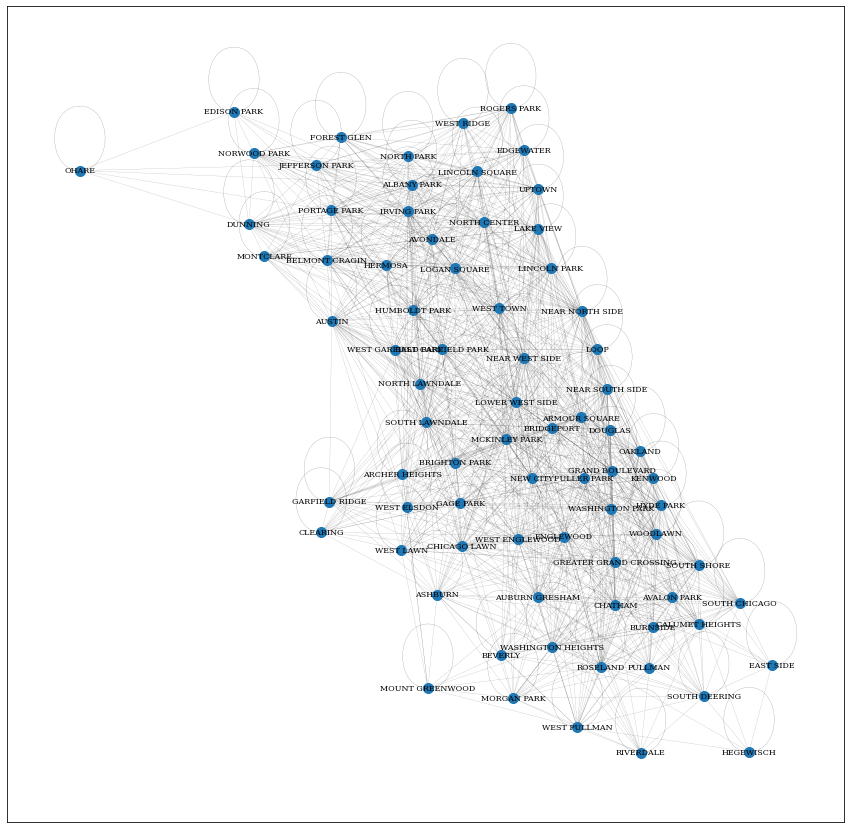

In [ ]:
fig, ax =  plt.subplots(figsize=(15,15))
nx.draw_networkx(Scooters, ax=ax, node_size=100, pos=ComPos, style='dotted', width=0.2, font_family='serif', font_size=8) 

### Report top nodes by centrality

In [ ]:
# top 5 nodes in terms of degree centrality  
dgr = nx.degree_centrality(Scooters)
dgr_df = pd.DataFrame(dgr.items()).rename(columns={0: 'Community', 1: 'Degree'})
top_dgr = dgr_df.sort_values(by='Degree', ascending=False)
top_dgr.head()

,Community,Degree
28,NEAR WEST SIDE,0.736842
36,NEAR NORTH SIDE,0.684211
32,LOWER WEST SIDE,0.644737
64,WEST ENGLEWOOD,0.644737
58,NEW CITY,0.644737


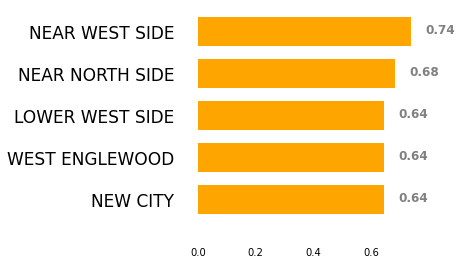

In [ ]:
fig2, ax2 =  plt.subplots(figsize=(4, 4))
y_pos = range(5, 0, -1)
ax2.barh(y_pos, top_dgr.Degree[:5], align='center', height=0.7, color='orange')
ax2.set_yticks(y_pos)
ax2.set_yticklabels(top_dgr.Community[:5], size=15)
ax2.set_frame_on(False) 
# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax2.spines[s].set_visible(False)
# Remove x, y Ticks
ax2.xaxis.set_ticks_position('none')
ax2.yaxis.set_ticks_position('none')
# Add padding between axes and labels
ax2.xaxis.set_tick_params(pad=20)
ax2.yaxis.set_tick_params(pad=20, labelsize=17)
# Add annotation to bars
for i in ax2.patches:
    plt.text(i.get_width()+0.05, i.get_y()+0.3,
          str(round((i.get_width()), 2)),
          fontsize=12, fontweight='bold',
          color='grey')

plt.show()

In [ ]:
# top 5 nodes in terms of Pagerank centrality  
prk = nx.pagerank(Scooters)
prk_df = pd.DataFrame(prk.items()).rename(columns={0: 'Community', 1: 'Pagerank'})
top_prk = prk_df.sort_values(by='Pagerank', ascending=False)
top_prk.head()

,Community,Pagerank
24,WEST TOWN,0.049031
28,NEAR WEST SIDE,0.045891
7,HYDE PARK,0.035415
22,LOGAN SQUARE,0.033442
44,LAKE VIEW,0.030602


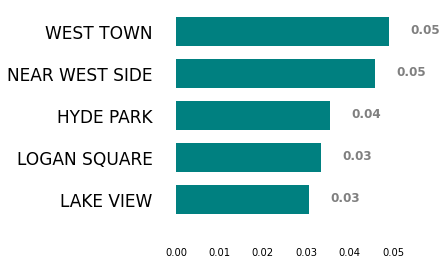

In [ ]:
fig2, ax2 =  plt.subplots(figsize=(4, 4))
y_pos = range(5, 0, -1)
ax2.barh(y_pos, top_prk.Pagerank[:5], align='center', height=0.7, color='teal')
ax2.set_yticks(y_pos)
ax2.set_yticklabels(top_prk.Community[:5], size=15)
ax2.set_frame_on(False) 
# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax2.spines[s].set_visible(False)
# Remove x, y Ticks
ax2.xaxis.set_ticks_position('none')
ax2.yaxis.set_ticks_position('none')
# Add padding between axes and labels
ax2.xaxis.set_tick_params(pad=20)
ax2.yaxis.set_tick_params(pad=20, labelsize=17)
# Add annotation to bars
for i in ax2.patches:
    plt.text(i.get_width()+0.005, i.get_y()+0.3,
          str(round((i.get_width()), 2)),
          fontsize=12, fontweight='bold',
          color='grey')

plt.show()

In [ ]:
# weights to show 
w=[d['weight'] for (u,v,d) in Scooters.edges(data=True)]
w = [0.1*np.log(i) for i in w]
w[:5]

[0.4672828834461906, 0.0, 0.0, 0.430406509320417, 0.10986122886681099]

In [ ]:
n = dgr_df.Degree * 800

In [ ]:
top_nodes = top_dgr.Community[:5]
top_labels = {i: i for i in top_nodes}
top_pos = {i: (community['centroid'].x[i], community['centroid'].y[i]) for i in top_nodes}

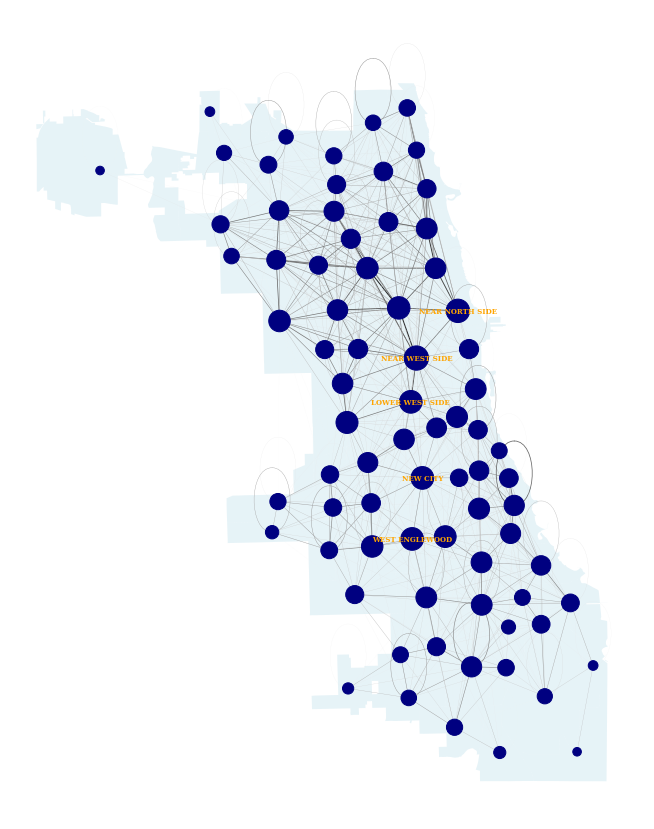

In [ ]:
fig, ax =  plt.subplots(figsize=(15,15))
community.geometry.plot(ax=ax, alpha=0.3, color='lightblue')
# community.geometry.boundary.plot(ax=ax, alpha=0.3, color='white', zorder=2)
nx.draw_networkx(Scooters, ax=ax, node_size=n, pos=ComPos, style='solid', node_color='navy',
                 width=w, font_family='serif', font_size=7, font_color='darkgrey',
                 edge_color=w, edge_cmap=plt.cm.binary, with_labels=False)  

# top5 nodes
nx.draw_networkx_labels(Scooters, top_pos, top_labels, font_size=7, font_family='serif', font_color='orange', font_weight='bold')
ax.set_frame_on(False) 

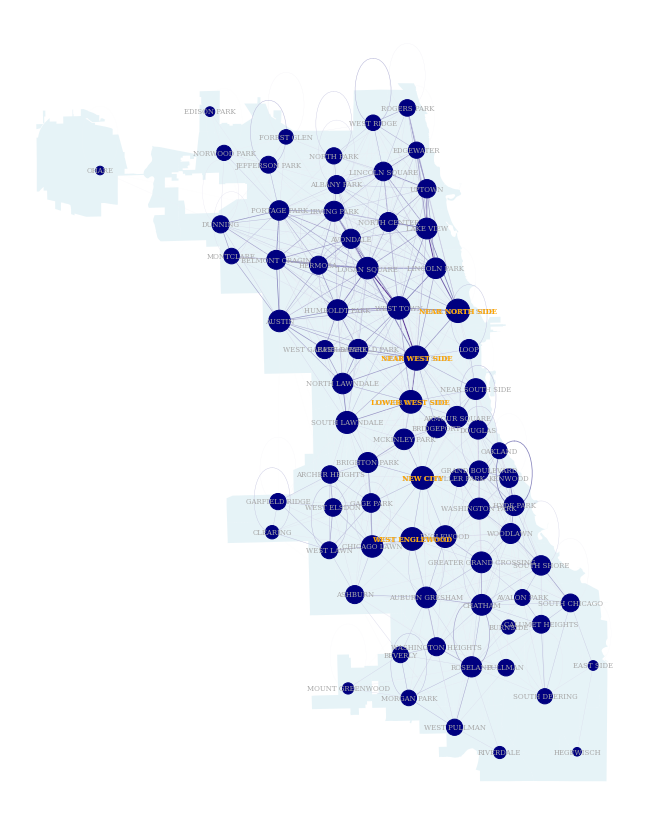

In [ ]:
fig, ax =  plt.subplots(figsize=(15,15))
community.geometry.plot(ax=ax, alpha=0.3, color='lightblue')
# community.geometry.boundary.plot(ax=ax, alpha=0.3, color='white', zorder=2)
nx.draw_networkx(Scooters, ax=ax, node_size=n, pos=ComPos, style='solid', node_color='navy',
                 width=w, font_family='serif', font_size=7, font_color='darkgrey',
                 edge_color=w, edge_cmap=plt.cm.Purples, with_labels=True)  

# top5 nodes
nx.draw_networkx_labels(Scooters, top_pos, top_labels, font_size=7, font_family='serif', font_color='orange', font_weight='bold')
ax.set_frame_on(False) 

Network partition modularity score and visualize the partition:
https://github.com/Casyfill/pyCombo

max_communities=3, modularity=0.61548
max_communities=4, modularity=0.68674
max_communities=5, modularity=0.71765
max_communities=6, modularity=0.73642
max_communities=7, modularity=0.74722
max_communities=8, modularity=0.75341
max_communities=9, modularity=0.75669
max_communities=10, modularity=0.75869
max_communities=11, modularity=0.76043
max_communities=12, modularity=0.76051
max_communities=13, modularity=0.76116
max_communities=14, modularity=0.76120


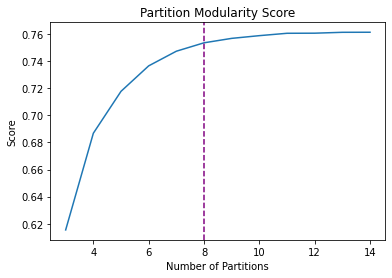

In [ ]:
M = []
for i in range(3, 15):
    _, modularity = pycombo.execute(Scooters, max_communities=i, return_modularity=True, random_seed=0000)
    M.append(modularity)
    print('max_communities=%d, modularity=%.5f' % (i, modularity))

plt.plot(range(3, 15), M)
plt.axvline(x=8, color='purple', ls='--')
plt.title('Partition Modularity Score')
plt.xlabel('Number of Partitions')
plt.ylabel('Score')
plt.show()

In [ ]:
partition, modularity = pycombo.execute(Scooters, return_modularity=True, max_communities=8, random_seed=0000)
print(f'Partition modularity: {modularity:.5f}')

Partition modularity: 0.75341


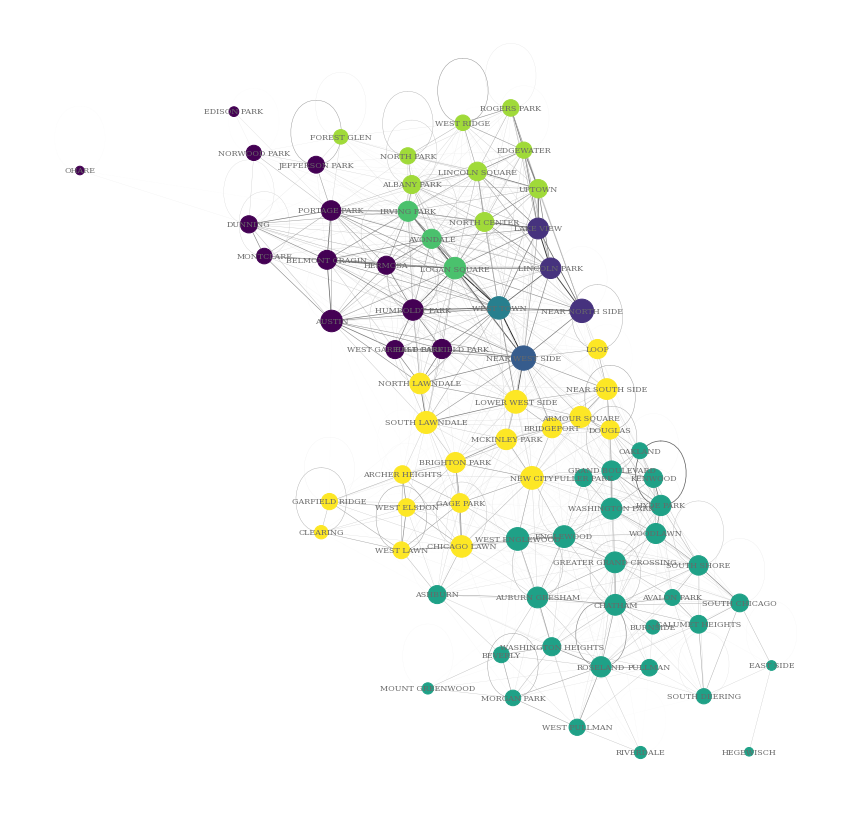

In [ ]:
fig, ax =  plt.subplots(figsize=(15, 15))
nx.draw_networkx(Scooters, ax=ax, pos=ComPos, with_labels=True, node_size=n, 
                 style='solid', width=w, node_color=list(partition.values()), 
                 font_family='serif', font_size=8, font_color='dimgrey',
                 edge_color=w, edge_cmap=plt.cm.binary)
ax.set_frame_on(False) 
plt.show()
# savefig('partition.png', transparent=True)

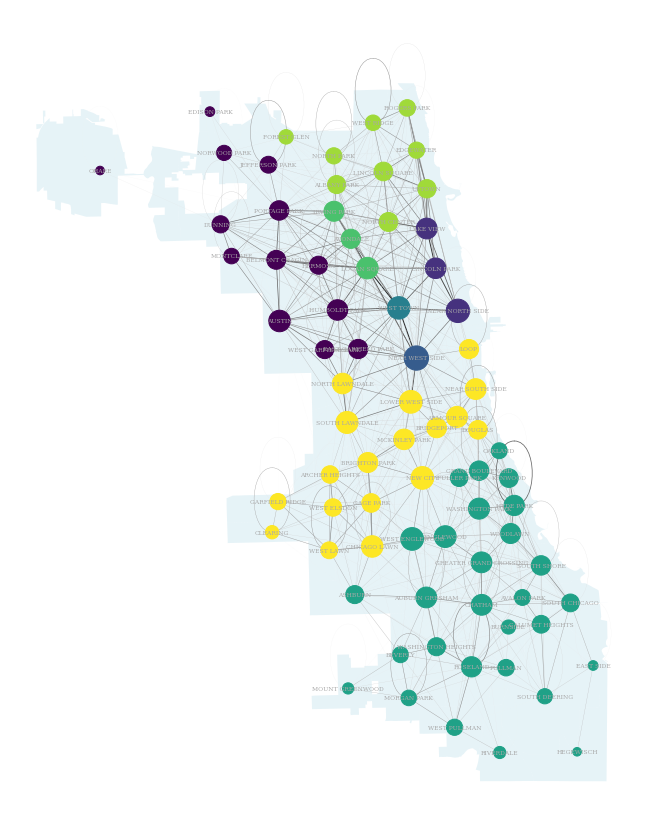

In [ ]:
fig, ax =  plt.subplots(figsize=(15, 15))
community.geometry.plot(ax=ax, alpha=0.3, color='lightblue')
nx.draw_networkx(Scooters, ax=ax, pos=ComPos, with_labels=True, node_size=n, 
                 style='solid', width=w, node_color=list(partition.values()), 
                 font_family='serif', font_size=6, font_color='darkgrey',
                 edge_color=w, edge_cmap=plt.cm.binary)
ax.set_frame_on(False) 
plt.show()

In [ ]:
result = pd.DataFrame(partition.items()).rename(columns={0:'community', 1:'partition'})
result

,community,partition
0,DOUGLAS,7
1,OAKLAND,4
2,FULLER PARK,4
3,GRAND BOULEVARD,4
4,KENWOOD,4
...,...,...
72,MOUNT GREENWOOD,4
73,MORGAN PARK,4
74,OHARE,0
75,EDGEWATER,6


In [ ]:
result['count'] = 1
result_g = result.groupby('partition').sum()
result_g

,count
partition,
0,13
1,3
2,1
3,1
4,29
5,3
6,9
7,18


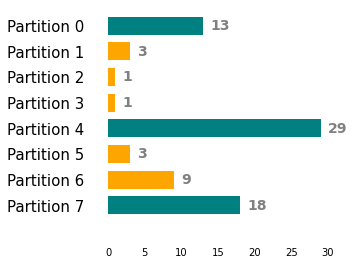

In [ ]:
fig2, ax2 =  plt.subplots(figsize=(4, 4))
y_pos = range(8, 0, -1)
c = ['orange']*8
for i in [0, 4, 7]:
    c[i] = 'teal'
ax2.barh(y_pos, result_g['count'], align='center', height=0.7, color=c)
ax2.set_yticks(y_pos)
ax2.set_yticklabels(['Partition %d'% i for i in result_g.index], size=15)
ax2.set_frame_on(False) 
# Remove axes splines
for s in ['top', 'bottom', 'left', 'right']:
    ax2.spines[s].set_visible(False)
# Remove x, y Ticks
ax2.xaxis.set_ticks_position('none')
ax2.yaxis.set_ticks_position('none')
# Add padding between axes and labels
ax2.xaxis.set_tick_params(pad=20)
ax2.yaxis.set_tick_params(pad=20, labelsize=15)
# Add annotation to bars
for i in ax2.patches:
    plt.text(i.get_width()+1, i.get_y()+0.2,
          str(round((i.get_width()), 2)),
          fontsize=14, fontweight='bold',
          color='grey')

plt.show()

In [ ]:
nodes_0 = result[result.partition==0]['community'].tolist()
nodes_4 = result[result.partition==4]['community'].tolist()
nodes_7 = result[result.partition==7]['community'].tolist()

In [ ]:
def partition_draw(nodes_list, options, edge_tune=0.5, node_tune=1000):
    
    # create weighted edge list
    edges_list = []
    for (u, v, d) in Scooters.edges(data=True):
        if (u in nodes_list) & (v in nodes_list):
            edges_list.append((u, v, d['weight']))

    # create a dictionary of community locations
    Pos = {i: (community['centroid'].x[i], community['centroid'].y[i]) for i in nodes_list}

    # create a network with city names as nodes
    Par = nx.Graph()
    Par.add_nodes_from(nodes_list)

    # create list of edges and weights as tuples
    Par.add_weighted_edges_from(edges_list)

    # weights as edge size
    w = [edge_tune * np.log(d['weight']) for (u,v,d) in Par.edges(data=True)]
    
    # Pagerank centrality as node size
    prk = nx.pagerank(Par)
    prk_df = pd.DataFrame(prk.items()).rename(columns={0: 'Community', 1: 'Pagerank'})
    n = prk_df.Pagerank * node_tune
    top_prk = prk_df.sort_values(by='Pagerank', ascending=False)

    # draw
    fig, ax =  plt.subplots(figsize=(10, 10))
    nx.draw_networkx(Par, ax=ax, pos=Pos, width=w, node_size=n, edge_color=w, edge_cmap=plt.cm.binary, **options)
    ax.set_frame_on(False) 

    fig2, ax2 =  plt.subplots(figsize=(4, 4))
    y_pos = range(5, 0, -1)
    ax2.barh(y_pos, top_prk.Pagerank[:5], align='center', height=0.7, color='gold')
    ax2.set_yticks(y_pos)
    ax2.set_yticklabels(top_prk.Community[:5], size=15)
    ax2.set_frame_on(False) 
    # Remove axes splines
    for s in ['top', 'bottom', 'left', 'right']:
        ax2.spines[s].set_visible(False)
    # Remove x, y Ticks
    ax2.xaxis.set_ticks_position('none')
    ax2.yaxis.set_ticks_position('none')
    # Add padding between axes and labels
    ax2.xaxis.set_tick_params(pad=20)
    ax2.yaxis.set_tick_params(pad=20, labelsize=17)
    # Add annotation to bars
    for i in ax2.patches:
        plt.text(i.get_width()+0.01, i.get_y()+0.3,
             str(round((i.get_width()), 2)),
             fontsize=12, fontweight='bold',
             color='grey')

    plt.show()

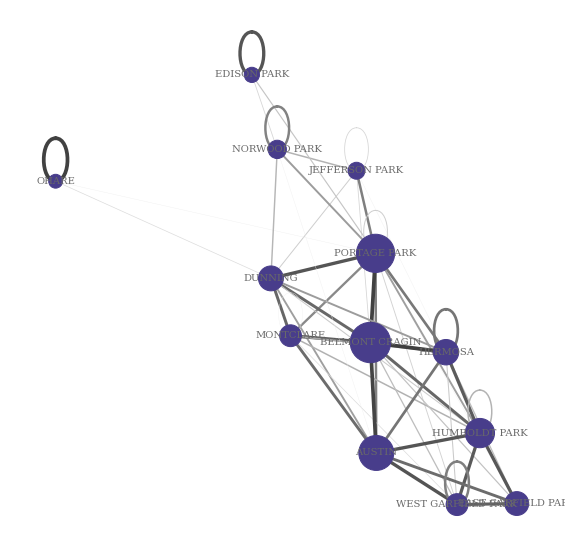

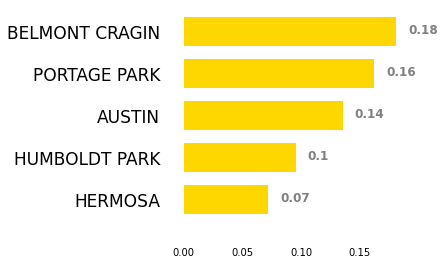

In [ ]:
style_options = {
    "node_color": 'darkslateblue',
    "with_labels": True,
    "font_color": 'dimgrey',
    "font_size": 10,
    "font_family": 'serif',
    "style": 'solid'
    }
partition_draw(nodes_0, style_options, edge_tune=0.5, node_tune=9000)

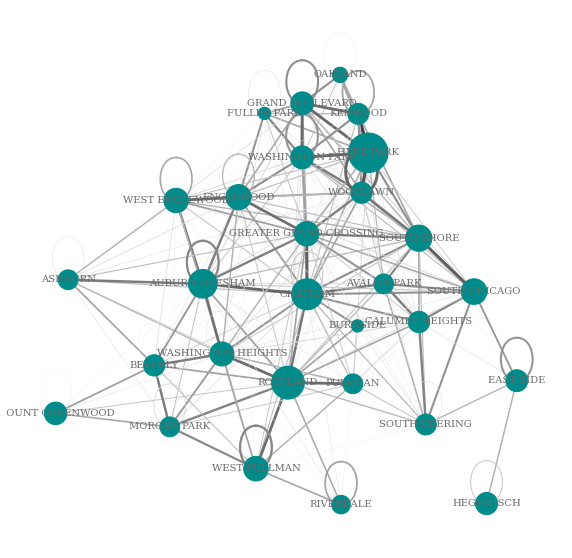

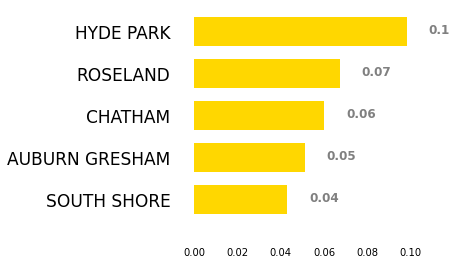

In [ ]:
style_options = {
    "node_color": 'darkcyan',
    "with_labels": True,
    "font_color": 'dimgrey',
    "font_size": 10,
    "font_family": 'serif',
    "style": 'solid'
    }
partition_draw(nodes_4, style_options, edge_tune=0.5, node_tune=16000)

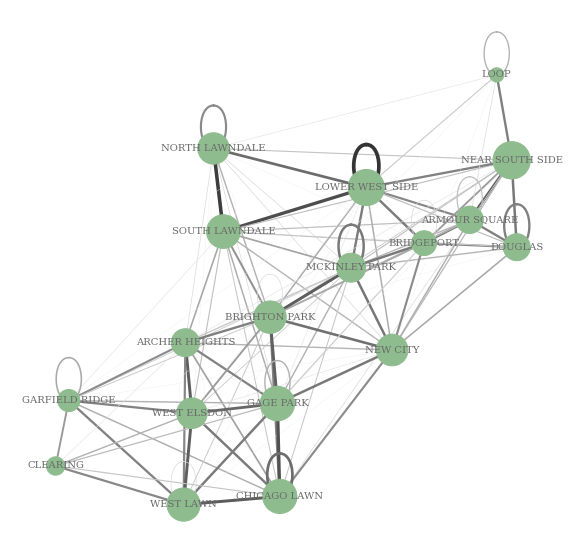

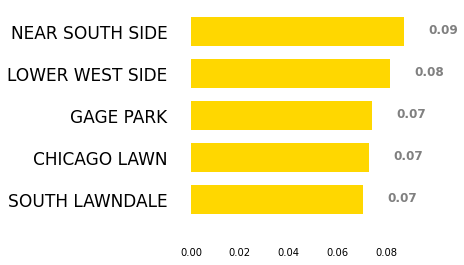

In [ ]:
style_options = {
    "node_color": 'darkseagreen',
    "with_labels": True,
    "font_color": 'dimgrey',
    "font_size": 10,
    "font_family": 'serif',
    "style": 'solid'
    }
partition_draw(nodes_7, style_options, edge_tune=0.5, node_tune=16000)